In [7]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind


def get_distribution(ps,ss,sigma,half_win,total_len,sample_rate):
#         x,y=get_distribution([10],[20],0.5,2,60,10)
#         plt.plot(x,y[:,:2])
        t= int((total_len-2*half_win)*sample_rate+1)
        st=half_win*sample_rate
        x= np.arange(st,t+st,1)/sample_rate
        y_n=np.ones(t)
        y_p=np.zeros(t)
        y_s=np.zeros(t)
        for p in ps:
            t_p=stats.norm.pdf(x, (p), sigma)
            y_p+=t_p/t_p.max()
            
        for s in ss:
            t_s=stats.norm.pdf(x, (s), sigma)
            y_s+=t_s/t_s.max()
        y_n=y_n-y_p-y_s
        y=np.vstack((y_p,y_s,y_n))
        y=np.swapaxes(y,0,1)
        
        return x,y

    
def cal_entropy(y1,y2):
    # y1 true, y2 predict
    n=len(y1)
    ans=0
    for i in range(3):
        prob=y2[:,i]
        x=np.where(prob>0.0000000001, prob, -10)
        np.log10(x,out=x,where=x>0)
        tmp=-y1[:,i]*x
        ans+=sum(tmp)
    return ans/n


def pre_recall(p,s,p_picks,s_picks):
    threshold=0.5
    p_len=len(p_picks)
    s_len=len(s_picks)
    p_match=0
    s_match=0
    p_err=-999
    s_err=-999
    if p_len>0:
        tp=np.abs(np.array(p_picks)-p).min()
        if tp<threshold:
            p_match=1
            p_err=tp
    if s_len>0:
        ts=np.abs(np.array(s_picks)-s).min()
        if ts<threshold:
            s_match=1
            s_err=ts
    return p_match,s_match,p_len,s_len,p_err,s_err

# def pick_picks(ts,tt,min_proba):
#     prob_S = ts[:,1]
#     prob_P = ts[:,0]
#     prob_N = ts[:,2]

#     trigs = trigger_onset(prob_P, min_proba, 0.1)
#     p_picks = []
#     s_picks = []
#     for trig in trigs:
#         if trig[1] == trig[0]:
#             continue
#         pick = np.argmax(ts[trig[0]:trig[1], 0])+trig[0]
#         p_picks.append(round(tt[pick],2))

#     trigs = trigger_onset(prob_S, min_proba, 0.1)
#     for trig in trigs:
#         if trig[1] == trig[0]:
#             continue
#         pick = np.argmax(ts[trig[0]:trig[1], 1])+trig[0]
#         s_picks.append(round(tt[pick],2))
#     return p_picks,s_picks

def pick_picks(ts,tt,min_proba,sample_rate):
    prob_S = ts[:,1]
    prob_P = ts[:,0]
    prob_N = ts[:,2]
    itp = detect_peaks(prob_P, mph=min_proba, mpd=0.5*sample_rate, show=False)
    its = detect_peaks(prob_S, mph=min_proba, mpd=0.5*sample_rate, show=False)
    p_picks=tt[itp]
    s_picks=tt[its]
    p_prob=ts[itp]
    s_prob=ts[its]
    return p_picks,s_picks,p_prob,s_prob

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

#####################
# Hyperparameters
min_proba = 0.95 # Minimum softmax probability for phase detection
freq_min = 3.0
freq_max = 20.0
filter_data = True
decimate_data = False # If false, assumes data is already 100 Hz samprate
n_shift = 10 # Number of samples to shift the sliding window at a time
n_gpu = 1 # Number of GPUs to use (if any)
#####################
batch_size = 1000*3

half_dur = 2.00
only_dt = 0.01
n_win = int(half_dur/only_dt)
n_feat = 2*n_win

#-------------------------------------------------------------

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided


sample_rate=10
def forward_model(model_cnn,model_rnn,dataset,flag=True,intermediate=False):
    dt = 0.01
    length=dataset[0,:,0].size
    num=len(dataset)
    size=sliding_window( dataset[0,:,0], n_feat, stepsize=n_shift).shape[0]
    tt = (np.arange(0,  length, n_shift) + n_win) * dt
    if intermediate:
        tm = np.zeros((num,size,128))
    ts = np.zeros((num,size,3))
    for c, data in enumerate(tqdm(dataset)):

        sliding_N = sliding_window( data[:,0], n_feat, stepsize=n_shift)
        sliding_E = sliding_window( data[:,1], n_feat, stepsize=n_shift)
        sliding_Z = sliding_window( data[:,2], n_feat, stepsize=n_shift)
        tr_win = np.zeros((sliding_N.shape[0], n_feat, 3))
        tr_win[:,:,0] = sliding_N
        tr_win[:,:,1] = sliding_E
        tr_win[:,:,2] = sliding_Z
        tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None]
        tt = tt[:tr_win.shape[0]]
        
        if intermediate:
            layer_output=model_cnn.layers[6].output
            intermediate_model=tf.keras.models.Model(inputs=model_cnn.input,outputs=layer_output)
            tm[c] = intermediate_model.predict(tr_win, batch_size=64)
            print(tm.shape)
        else:
            ts[c] = model_cnn.predict(tr_win, batch_size=64)
#     if intermediate:
#         sliding_N = sliding_window(tm[0,:,0], n_feat, stepsize=n_shift)
#         tr_win = np.zeros((sliding_N.shape[0], n_feat, 128))
#         for i in range(128):
#             tr_win[:,:,i] = sliding_window( tm[0,:,i], n_feat, stepsize=n_shift)
#         y1=model_rnn.predict(tr_win,batch_size=10)

#         y_pred=np.zeros((1,tm.shape[1],3))
#         for i in range(len(y1)):
# #             y_pred[0,i*n_shift:i*n_shift+n_feat,0]=np.maximum(y1[i,:,0],y_pred[0,i*n_shift:i*n_shift+n_feat,0])
#             y_pred[0,i*n_shift:i*n_shift+n_feat,:]=y1[i,:,:]

#         return tt,tm,y_pred

    if intermediate:    
        size=300
        res=tm.shape[1]%size
        inputs=tm[:,:-res].reshape(-1,size,128)
        
        y1=model_rnn.predict(inputs,batch_size=1)
        y1=y1.reshape(1,-1,3)
        y2=model_rnn.predict(tm[:,-res:],batch_size=1)
        y_pred=np.concatenate((y1, y2), axis=1)
        return tt,tm,y_pred
        
#     if intermediate:        
#         y_pred=model_rnn.predict(tm,batch_size=1)
#         return tt,tm,y_pred

    if flag:
        y_pred=model_rnn.predict(ts,batch_size=1)
        return tt,ts,y_pred
    else:
        return tt,ts
    



In [3]:
import numpy as np
import matplotlib,h5py,os
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from obspy.signal.trigger import trigger_onset
from tqdm import tqdm
from datetime import datetime
from contextlib import redirect_stdout
import random
from IPython.utils import io
from glob import glob
import json
from obspy import read

# sklearn packages
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve

# keras packages
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model

from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Flatten,Dense,Dropout,BatchNormalization
from keras.utils import np_utils
import tensorflow as tf

matplotlib.rc('font', **{'size'   : 15})

import warnings
warnings.filterwarnings("ignore")


from obspy.core.utcdatetime import UTCDateTime
from obspy.geodetics import base
from obspy.taup import TauPyModel
from obspy.core.event.catalog import read_events


In [18]:
seisS1=np.genfromtxt('South/04.txt') #direct wave
seisS2=np.genfromtxt('South/07.txt') #direct wave
tseis1='South'
seis1=np.hstack((seisS1,seisS2))
seisN1=np.genfromtxt('North/01.txt'); #reverse wave
seisN2=np.genfromtxt('North/05.txt'); #reverse wave
tseis2='North'
seis2=np.hstack((seisN1,seisN2))


nodata=300
dt=1/1000
nostations=48
dx=5

from obspy.signal.detrend import polynomial
from obspy.signal.filter import bandpass


ValueError: Sliding window size may not exceed size of selected axis

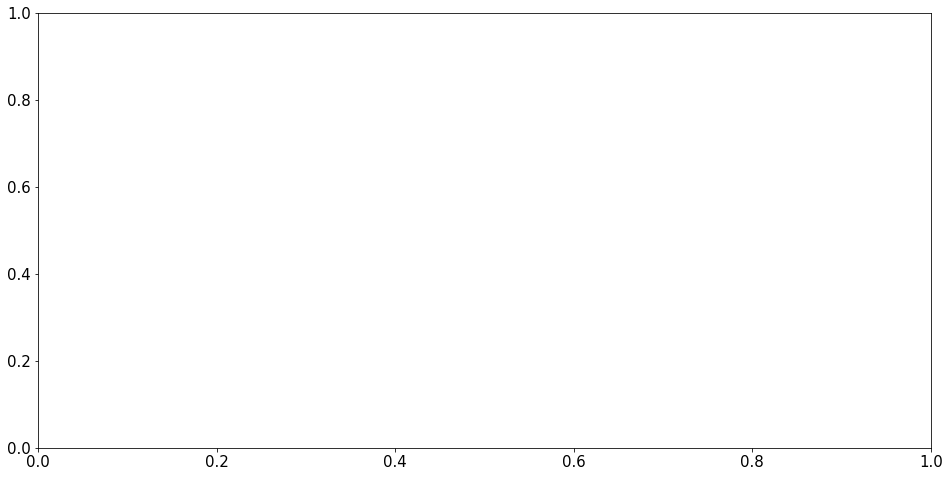

In [22]:

ans=np.zeros((48,nodata,3))

def plotseis(seis,doublecolor=False):
    fig =plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    for i in range(nostations):
    #     tr.normalize()
        tr=seis[:nodata,i]
    #     tr = minmax_scale(tr, feature_range=(-1,1))
        tr=polynomial(tr, order=3, plot=False)  
        tr=bandpass(tr,0.1,40,1/dt)
        
        tmp=np.zeros((1,nodata,3))
        tmp[0,:,0]=tr
        tt,tm,y_pred=forward_model(model_cnn,model_rnn,tmp,flag=True,intermediate=True)
        ans[i,:,:]=y_pred
        np.save(sta_name,y_pred)
        
        tr=tr/tr.max()*5
        dist = dx*i+dx
        y = np.arange(nodata)*dt
        x = tr+dist
        ax.plot(x,y,'k')
        ax.fill_betweenx(y,x,dist,x > dist, color='r', alpha = 0.8)
        if doublecolor:
            ax.fill_betweenx(y,x,dist,x < dist, color='b', alpha = 0.8)

    ax.set_xlabel("Station Dist")    
    ax.set_ylabel("sec")    
    ax.set_ylim(0,0.3)
    ax.set_xlim(0,250)
#     plt.tight_layout()
    plt.gca().invert_yaxis()

    return fig, ax
fig, ax =plotseis(seis1,doublecolor=True)

fig, ax =plotseis(seis2,doublecolor=True)


In [8]:
model_cnn=load_model('./CNNclassifier.h5')
model_rnn=load_model('./RNNclassifier.h5')


In [ ]:

start=0
steps=start+3600*24
#         length=min((steps-start)*100,len(st[0].data))
tmp=np.zeros((1,(steps-start)*100+1,3))
#         print(length,tmp.shape)
max_length=min(min(min((steps-start)*100+1,len(st[0].data)),len(st[1].data)),len(st[2].data))
tmp[0,:max_length,0]=np.transpose(st[1][:max_length]) # N
tmp[0,:max_length,1]=np.transpose(st[0][:max_length]) # E
tmp[0,:max_length,2]=np.transpose(st[2][:max_length]) # Z


tmp[0,:,0]=tmp[0,:,0]-np.average(tmp[0,:,0])
tmp[0,:,1]=tmp[0,:,1]-np.average(tmp[0,:,1])
tmp[0,:,2]=tmp[0,:,2]-np.average(tmp[0,:,2])


tt,tm,y_pred=forward_model(model_cnn,model_rnn,tmp,flag=True,intermediate=True)

np.save(sta_name,y_pred)